# Required import

In [1]:
import numpy as np
from sklearn import svm

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin

from src.utils import load_and_regularize_covariance_matrices, calculate_covariance_means
from pyriemann_qiskit.classification import QuanticSVM, QuanticNCH
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from pyriemann_qiskit.utils.hyper_params_factory import gen_x_feature_map, gen_z_feature_map

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann_qiskit.ensemble import JudgeClassifier
from sklearn.ensemble import RandomForestClassifier

from pyriemann_qiskit.visualization.manifold import plot_manifold
from pyriemann.utils.viz import plot_biscatter, plot_bihist, plot_cov_ellipse

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

# Define custom spatial filtering

In [5]:
class PCA_SPD(TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        new_dataset = np.zeros((X.shape[0], self.n_components, self.n_components))
        for i in range(X.shape[0]):
            covariance_to_reduce = X[i]
            eigenvalues, eigenvectors = np.linalg.eigh(covariance_to_reduce) # Calculate eigenvalues and eigenvectors            
            idx = eigenvalues.argsort()[::-1] # Sort eigenvalues in descending order
            eigenvectors = eigenvectors[:,idx][:,:self.n_components] # Sort eigenvectors according to eigenvalues and get the first n_components
            reduced_covariance = eigenvectors.T @ np.diag(eigenvalues) @ eigenvectors            
            new_dataset[i] = reduced_covariance            
        return new_dataset 

# Extract data

In [2]:
c_dataset = load_and_regularize_covariance_matrices(deep_features_type='covs_DN20', group_type='CG')
c_dataset_covs = calculate_covariance_means(c_dataset) #Generalized eigenvalue covariance mean
c_nsubjects = len(c_dataset_covs)
c_nvideos = len(c_dataset_covs[0])
c_covdim = len(c_dataset_covs[0][0])
c_dataset_covs_reshaped = np.array(c_dataset_covs).reshape((c_nsubjects * c_nvideos, c_covdim, c_covdim))

pk_dataset = load_and_regularize_covariance_matrices(deep_features_type='covs_DN20', group_type='PG')
pk_dataset_covs = calculate_covariance_means(pk_dataset)
pk_nsubjects = len(pk_dataset_covs)
pk_nvideos = len(pk_dataset_covs[0])
pk_covdim = len(pk_dataset_covs[0][0])
pk_dataset_covs_reshaped = np.array(pk_dataset_covs).reshape((pk_nsubjects * pk_nvideos, pk_covdim, pk_covdim))
X = np.concatenate([c_dataset_covs_reshaped, pk_dataset_covs_reshaped], axis=0)
y = np.concatenate([np.zeros(c_nsubjects * c_nvideos), np.ones(pk_nsubjects * pk_nvideos)])

Patients:   0%|          | 0/11 [00:00<?, ?it/s]

Patients [Covariance mean]: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


# Visualize data

AttributeError: 'Ellipse' object has no attribute 'transData'

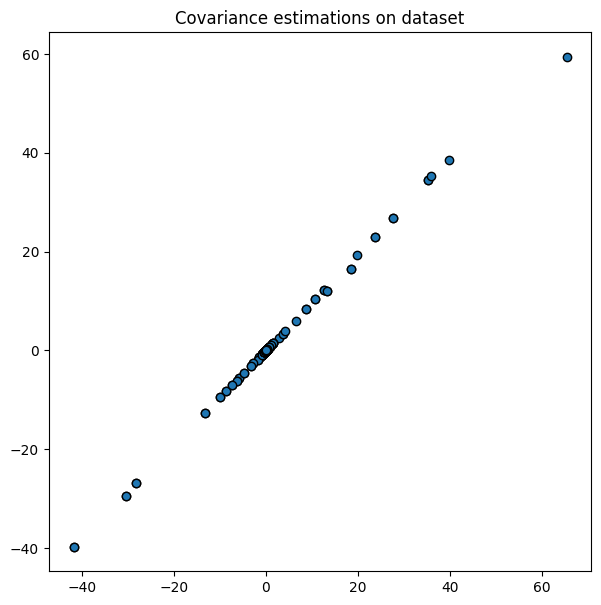

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Covariance estimations on dataset")
ax.scatter(X[0], X[1], c='C0', edgecolors="k", label='Inputs')
X_reduced = PCA_SPD(n_components=2).fit(X, y).transform(X)
for x in X_reduced:
    ax = plot_cov_ellipse(ax, x)

# Define pipelines

In [56]:
pipe_ts_svm = make_pipeline(TangentSpace(metric='logeuclid'), svm.SVC())
pipe_ts_qsvm = make_pipeline(TangentSpace(metric='logeuclid'), PCA(n_components=10), QuanticSVM())
pipe_ts_qsvm2 = make_pipeline(
    # Whitening(metric="logeuclid", dim_red={'n_components': 2}),
    PCA_SPD(n_components=2),
    TangentSpace(metric='logeuclid'),
    QuanticSVM(gen_feature_map=gen_x_feature_map(), pegasos=False))
pipe_mdm = make_pipeline(
    PCA_SPD(n_components=2),
    MDM(metric='logeuclid'))
pipe_nch = make_pipeline(
    PCA_SPD(n_components=2),
    QuanticNCH(
        n_hulls_per_class=1,
        n_samples_per_hull=3,
        n_jobs=12,
        subsampling="random",
        quantum=False,
    )
)
pipe_classical = make_pipeline(
    PCA_SPD(n_components=2),
    TangentSpace(metric='logeuclid'),
    svm.SVC()
)
pipe_lda = make_pipeline(
    PCA_SPD(n_components=2),
    TangentSpace(metric='logeuclid'),
    svm.SVC()
)
pipe_ens = make_pipeline(
    PCA_SPD(n_components=2),
    TangentSpace(metric='logeuclid'),
    JudgeClassifier(
        clfs=[LDA(),QuanticSVM(gen_feature_map=gen_x_feature_map(), pegasos=False)],
        judge=RandomForestClassifier(n_estimators=100)
    )
)

[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier


# Evaluate

In [6]:
cross_val_score(pipe_ts_qsvm2, X, y, scoring="balanced_accuracy", cv=StratifiedKFold(n_splits=3)).mean()

                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (117, 3)
[QClass]  Feature dimension =  3
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  9060
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (117, 3)
[QClass]  Feature dimension =  3
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  9060
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (118, 3)
[QClass]  Feature dimension =  3
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  9060
[QClass]  SVM initiating algorithm
[QClass]  Training...
[QClass]  Prediction finished.


0.9555555555555556

# Grid Search

In [ ]:
# Score with gridsearch
# Leave 20 percent out, to avoid biases in the choice of the hyperparameter
# (how well this tuned pipeline is doing with new data?)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)
params = {
    "quanticsvm__C": [0.1, 1, 10],
    "quanticsvm__gamma": ["auto", "scale"],
    "quanticsvm__gen_feature_map": [gen_z_feature_map(), gen_x_feature_map()],
    "tangentspace__metric": ["riemann", "logeuclid"],
    "pca_spd__n_components": [2, 3]
}
gs = GridSearchCV(pipe_ts_qsvm2, params, scoring="balanced_accuracy", cv=StratifiedKFold(n_splits=3))
gs.fit(X_train, y_train)
print(gs.best_params_)
print(f'best score {gs.best_score_}')
score = gs.score(X_test, y_test)
print(f'validation score {score}')

# Evaluate difference in predictions

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.9)
y_pred_classical = pipe_classical.fit(X_train, y_train).predict(X_test)
y_pred_quantum = pipe_ts_qsvm2.fit(X_train, y_train).predict(X_test)
from sklearn.metrics import balanced_accuracy_score, jaccard_score
score_classical = balanced_accuracy_score(y_test, y_pred_classical)
print(score_classical)
score_quantum = balanced_accuracy_score(y_test, y_pred_quantum)
print(score_quantum)
print((y_pred_classical == y_pred_quantum).sum() / len(X_test))
print(y_pred_classical)
print(y_pred_quantum)